In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging

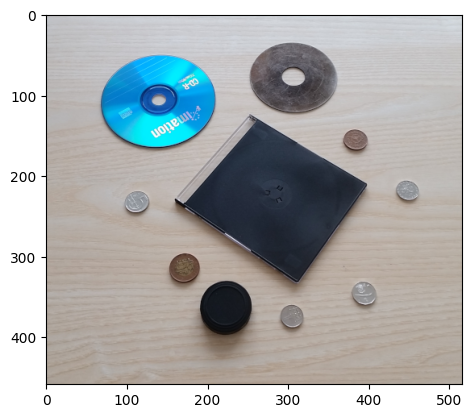

In [3]:
image=plt.imread(".\Data\cd_box.png")
plt.imshow(image)

In [88]:
class BoundingBox:    
    size=(0,0)
    position=(0,0)

    def __init__(self,size:tuple,position:tuple):
        if len(size)!=2 or len(position)!=2:
            return
        self.shape=np.array(size).astype(np.int32)
        self.position=position

def create_2Drot(angle:float)->np.array:
    phi_rad = np.radians(angle)
    c, s = np.cos(phi_rad), np.sin(phi_rad)
    R = np.array(((c, -s,0), (s, c,0),(0,0,1)))
    return R

def create_2DTranslation(translation_vector:np.array)->np.array:
    if translation_vector.ndim!=1:
        logging.warning("The input is not a vector, returning identity.")
        return np.identity(3)
    if translation_vector.shape[0]!=2: 
        logging.warning("The input is not a 2D vector!")
        return np.identity(3)
    
    translation_matrix=np.array([
        [1,0,translation_vector[0]],
        [0,1,translation_vector[1]],
        [0,0,1]
    ])

    return translation_matrix


def get_bounding_box(angle:float, image_size:tuple)->BoundingBox:
    dx,dy=image_size[0]/2,image_size[1]/2
    corners=[
        np.array([-dx,-dy]),
        np.array([dx,-dy]),
        np.array([dx,dy]),
        np.array([-dx,dy]), 
    ]
    rotated_corners=[]
    rotation_matrix=create_2Drot(angle)
    for corner in corners:
        homogeneous_corner=np.array([corner[0],corner[1],1])
        rotated_coordinate=rotation_matrix@homogeneous_corner
        rotated_corners.append(rotated_coordinate)

    x1=abs(rotated_corners[0][0]-rotated_corners[2][0])
    x2=abs(rotated_corners[1][0]-rotated_corners[3][0])
    y1=abs(rotated_corners[0][1]-rotated_corners[2][1])
    y2=abs(rotated_corners[1][1]-rotated_corners[3][1])
    
    x=max(x1,x2)
    y=max(y1,y2)

    bb=BoundingBox((x,y),(x/2,y/2))
    return bb

"""
1.Calculate the dimensions of the new image
2.Iterate through the pixels of the new image, transform them appropriately, and sample the original image with the transformed coordinates. 
"""
def rotate_img(image:np.array,angle):
    bounding_box=get_bounding_box(angle,image.shape)
    channels=image.ndim
    if channels==1:
        rotated_image=np.zeros((bounding_box.shape))
    elif channels==3:
        rotated_image=np.zeros((bounding_box.shape[0],bounding_box.shape[1],channels))
    dx,dy=image.shape[0]/2,image.shape[1]/2
    rotation_matrix=create_2Drot(angle)
    for i in range(rotated_image.shape[0]):
        for j in range(rotated_image.shape[1]):
            #Rotate the image pixels around the center, and round the values to be 
            #indices.
            translation=create_2DTranslation(np.array([-bounding_box.shape[0]/2,-bounding_box.shape[1]/2]))
            sample_translation=create_2DTranslation(np.array([dx,dy]))
            homogeneous_px_coordinate=np.array([i,j,1])
            final_transform=sample_translation@rotation_matrix@translation
            transformed_coordinates=final_transform@homogeneous_px_coordinate
            transformed_coordinates=transformed_coordinates.astype(np.int32)
            #Filter pixels outside of the original
            if 0<=transformed_coordinates[0]<image.shape[0] and 0<=transformed_coordinates[1]<image.shape[1]:
                rotated_image[i,j]=image[transformed_coordinates[0],transformed_coordinates[1]]
    return rotated_image
    

In [89]:
image.shape

(459, 516, 3)

In [97]:
rotated_image30=rotate_img(image,-30)
rotated_image45=rotate_img(image,45)
rotated_image230=rotate_img(image,230)

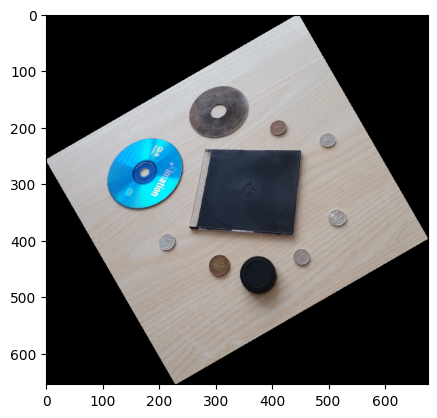

In [98]:
plt.imshow(rotated_image30)

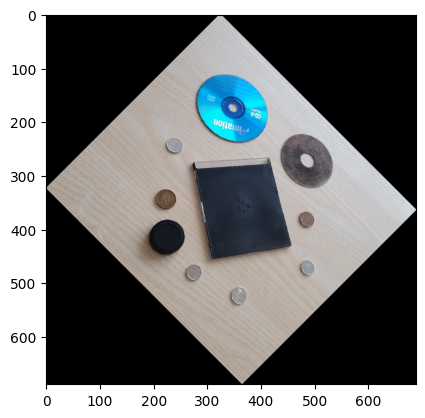

In [99]:
plt.imshow(rotated_image45)

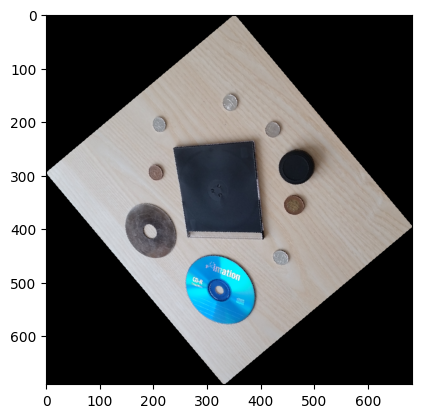

In [100]:
plt.imshow(rotated_image230)